Get the deploy folder from the output from the FINN compiler. Put it onto the PYNQ. THEN run the code cells below.

The code cell below sets the input and output shapes of the files that the model should be working with. You acccess the bit file thats loaded up, then put the dictionary, platform, and bitfile into the FINN example overlay. 


In [ ]:
# Uncoment and run the commmand below if 
#!pip install qonnx

In [1]:
#Point the system to the driver_base.py which live in that sys path. driver_base.py has a whole bunch of functions that are needed for the FINN overlay

import sys
sys.path.append('./deploy/driver')

In [7]:
from deploy.driver.driver import FINNExampleOverlay
from qonnx.core.datatype import DataType
import numpy as np

# Load image data
input_data = np.load("input.npy").astype(np.uint8)

#Test bitfile from Vivado bitstream generation to validate that its the same model as the resource usage report
# Load first overlay
bitfile_SELF_ATTEMPT = "deploy/bitfile/finn-accel.bit"

platform = "zynq-iodma"

_cifar10_cnv_io_shape_dict = {
    "idt": [DataType["UINT8"]],
    "odt": [DataType["UINT8"]],
    "ishape_normal": [(1, 32, 32, 3)],
    "oshape_normal": [(1, 1)],
    "ishape_folded": [(1, 1, 32, 32, 1, 3)],
    "oshape_folded": [(1, 1, 1)],
    "ishape_packed": [(1, 1, 32, 32, 1, 3)],
    "oshape_packed": [(1, 1, 1)],
    "input_dma_name": ["idma0"],
    "output_dma_name": ["odma0"],
    "number_of_external_weights": 0,
    "num_inputs": 1,
    "num_outputs": 1,
}

accel_poor = FINNExampleOverlay(bitfile_SELF_ATTEMPT, platform, io_shape_dict=_cifar10_cnv_io_shape_dict)

results_poor = []
for image in input_data:
    image = image.reshape((1, 32, 32, 3)).astype(np.uint8)
    output = accel_poor.execute(image)
    results_poor.append(int(output[0][0]))

np.save("results_poor.npy", np.array(results_poor))


In [8]:
# _cifar10_cnv_io_shape_dict = {
#     "ishape_normal": [(1, 32, 32, 3)],
#     "oshape_normal": [(1, 1)],
#     "ishape_folded": [(1, 1, 32, 32, 1, 3)],
#     "oshape_folded": [(1, 1, 1)],
#     "ishape_packed": [(1, 1, 32, 32, 1, 3)],
#     "oshape_packed": [(1, 1, 1)],
#     "idma_name": ["m_axi_hostmem"],
#     "odma_name": ["m_axi_hostmem"],   # Use the same for both input and output!
#     "ishape_normal": [(1, 32, 32, 3)],
#     "oshape_normal": [(1, 1)],
#     "num_input_vectors": 1,
#     "num_output_vectors": 1,
#     "num_inputs": 1,
#     "num_outputs": 1,
# }


bitfile_EXAMPLE = "deploy/bitfile/cnv-w2a2.bit"
# bitfile_VALIDATION = "deploy/bitfile/cnvW2A2-pynqZ1-Z2.bit"

accel_works = FINNExampleOverlay(bitfile_EXAMPLE, platform, io_shape_dict=_cifar10_cnv_io_shape_dict)

results_good = []
for image in input_data:
    image = image.reshape((1, 32, 32, 3)).astype(np.uint8)
    output = accel_works.execute(image)
    results_good.append(int(output[0][0]))

np.save("results_good.npy", np.array(results_good))


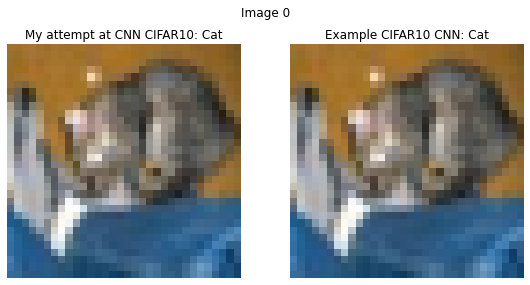

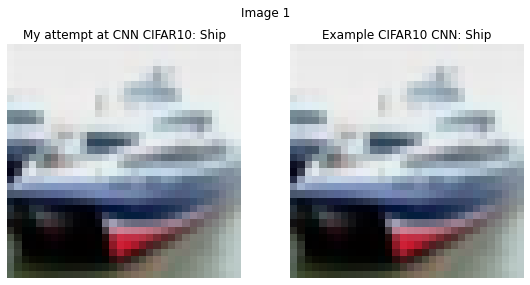

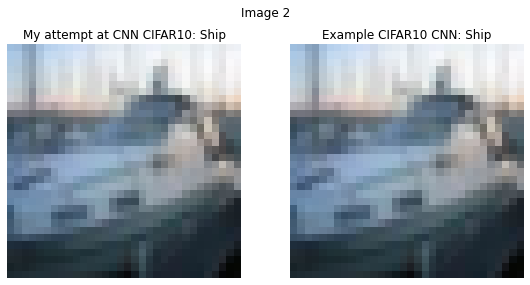

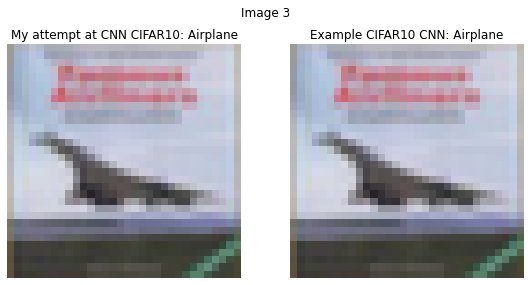

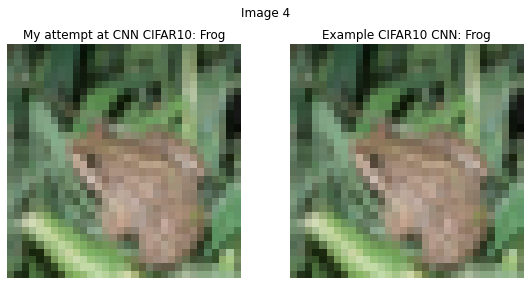

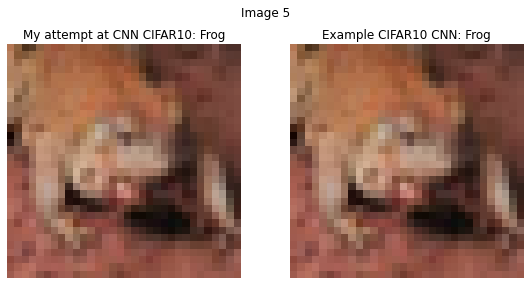

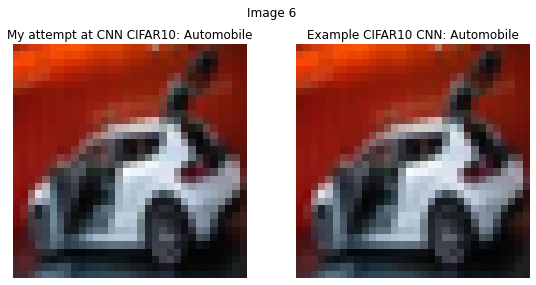

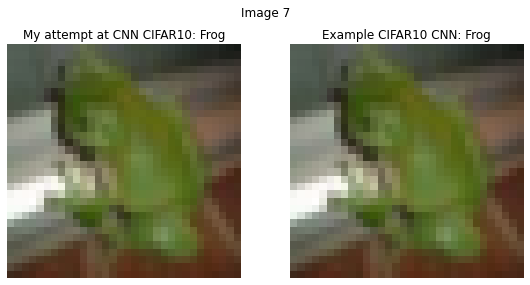

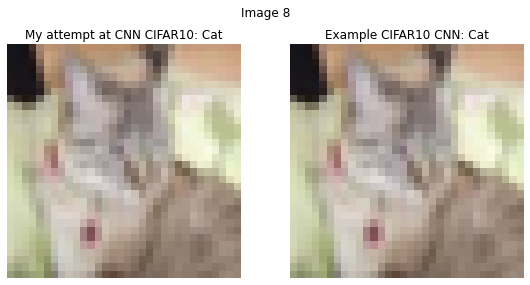

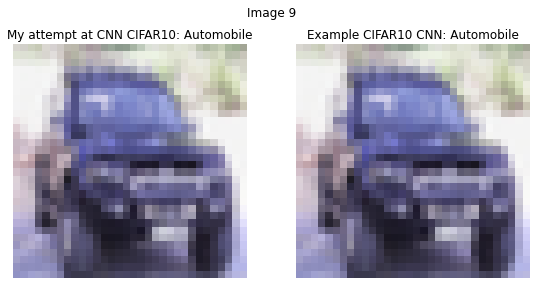

In [9]:
import matplotlib.pyplot as plt

results_poor = np.load("results_poor.npy")
results_good = np.load("results_good.npy")
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

for i in range(len(input_data)):
    image = input_data[i].reshape((32, 32, 3))
    pred_poor = results_poor[i]
    pred_good = results_good[i]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    axes[0].imshow(image)
    axes[0].set_title(f"My attempt at CNN CIFAR10: {labels[pred_poor]}")
    axes[0].axis("off")

    axes[1].imshow(image)
    axes[1].set_title(f"Example CIFAR10 CNN: {labels[pred_good]}")
    axes[1].axis("off")

    plt.suptitle(f"Image {i}")
    plt.tight_layout()
    plt.show()


The code cell below is similar to the code cell above except that it will test all 10,000 images from the CIFAR test set to determine accuracy of the model

In [59]:
import pickle
import numpy as np

# === Load test batch ===
with open("test_batch", "rb") as f:
    batch = pickle.load(f, encoding="latin1")

images = batch["data"].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype(np.uint8)
labels = np.array(batch["labels"])  # <- CIFAR-10 ground truth labels

# === Set up FINN overlay ===
from deploy.driver.driver import FINNExampleOverlay
from qonnx.core.datatype import DataType

my_io_shape_dict = {
    "idt": [DataType["UINT8"]],
    "odt": [DataType["UINT8"]],
    "ishape_normal": [[1, 32, 32, 3]],
    "oshape_normal": [[1, 10]],
    "ishape_folded": [[1, 32, 32, 3]],
    "oshape_folded": [[1, 10]],
    "ishape_packed": [[1, 32, 32, 3]],
    "oshape_packed": [[1, 10]],
    "input_dma_name": ["idma0"],
    "output_dma_name": ["odma0"],
    "num_inputs": 1,
    "num_outputs": 1,
    "number_of_external_weights": 0
}

# bitfile = "deploy/bitfile/finn-accel.bit"
bitfile = "deploy/bitfile/cnv-w2a2.bit"
platform = "zynq-iodma"
accel = FINNExampleOverlay(bitfile, platform, io_shape_dict=my_io_shape_dict)

# === Run full test set ===
correct = 0
for i in range(10000):
    img = images[i].reshape(1, 32, 32, 3)
    output = accel.execute(img)
    predicted = int(output[0][0]) 
    actual = labels[i]
    
    if predicted == actual:
        correct += 1
    
    if i % 500 == 0:
        print(f"Processed {i} images...")

accuracy = correct / 10000 * 100
print(f"Model accuracy on full CIFAR-10 test set: {accuracy:.2f}%")



Processed 0 images...
Processed 500 images...
Processed 1000 images...
Processed 1500 images...
Processed 2000 images...
Processed 2500 images...
Processed 3000 images...
Processed 3500 images...
Processed 4000 images...
Processed 4500 images...
Processed 5000 images...
Processed 5500 images...
Processed 6000 images...
Processed 6500 images...
Processed 7000 images...
Processed 7500 images...
Processed 8000 images...
Processed 8500 images...
Processed 9000 images...
Processed 9500 images...
Model accuracy on full CIFAR-10 test set: 88.63%
